In [1]:
import pandas as pd
import spacy

In [2]:
df = pd.read_csv('../data/processed/ai_data_clean.csv', index_col=0)
df.head()

,titles,summaries,len_summaries,terms
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,187,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...",206,"['cs.CV', 'cs.AI']"
7,Towards to Robust and Generalized Medical Imag...,"To mitigate the radiologist's workload, comput...",189,"['cs.CV', 'cs.AI']"
26,Segmenter: Transformer for Semantic Segmentation,Image segmentation is often ambiguous at the l...,179,"['cs.CV', 'cs.AI', 'cs.LG']"
34,Deep Reinforcement Learning in Computer Vision...,Deep reinforcement learning augments the reinf...,173,"['cs.CV', 'cs.AI']"


In [18]:
nlp = spacy.load("en_core_sci_sm")

In [21]:
text = df.iloc[500]['summaries']
print(text)
doc = nlp(text)
for ent in doc.ents:
    print(f"Named Entity '{ent.text}' with label '{ent.label_}'")

Being able to predict what may happen in the future requires an in-depth understanding of the physical and causal rules that govern the world. A model that is able to do so has a number of appealing applications, from robotic planning to representation learning. However, learning to predict raw future observations, such as frames in a video, is exceedingly challenging -- the ambiguous nature of the problem can cause a naively designed model to average together possible futures into a single, blurry prediction. Recently, this has been addressed by two distinct approaches: (a) latent variational variable models that explicitly model underlying stochasticity and (b) adversarially-trained models that aim to produce naturalistic images. However, a standard latent variable model can struggle to produce realistic results, and a standard adversarially-trained model underutilizes latent variables and fails to produce diverse predictions. We show that these distinct methods are in fact complemen

In [41]:
ents_text = [ent.text for ent in doc.ents]
for token in doc:
    if token.text in ents_text:
        print(token.text, "-->", token.dep_)

happen --> ccomp
physical --> amod
govern --> acl:relcl
model --> nsubj
representation --> compound
learning --> nmod
learning --> nsubj
observations --> dobj
frames --> nmod
video --> nmod
problem --> nmod
naively --> advmod
model --> dobj
futures --> dobj
approaches --> nmod
variational --> amod
model --> acl:relcl
stochasticity --> dobj
standard --> amod
model --> nsubj
standard --> amod
model --> nsubj
fails --> conj
diverse --> amod
predictions --> dobj
methods --> nsubj
predictions --> dobj
human --> amod
raters --> nmod
futures --> nmod
method --> compound
concurrent --> conj


In [12]:
next(doc.sents)

In this paper, we proposed a novel mutual consistency network (MC-Net+) to effectively exploit the unlabeled hard regions for semi-supervised medical image segmentation.

In [13]:
spacy.displacy.render(next(doc.sents), style="dep")

#### TFIDF + Kmeans

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from time import time
import matplotlib.pyplot as plt

We can play with different hyperparams (or use GridSearch):
- max_df
- max_features
- min_df

In [4]:
k=5

In [5]:
len(df)

5950

#### TFIDF

In [22]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=20, ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(df.summaries)

In [23]:
len(vectorizer.vocabulary_)

1657

#### LSA


Number of components = 4 and explained variance = 0.010710471581660101
Number of components = 10 and explained variance = 0.02236888649938594
Number of components = 15 and explained variance = 0.029998656009254457
Number of components = 20 and explained variance = 0.03686198310541934
Number of components = 50 and explained variance = 0.06747732190995642
Number of components = 100 and explained variance = 0.10477233512253373
Number of components = 150 and explained variance = 0.13435267488909383
Number of components = 200 and explained variance = 0.1598499892148691
Number of components = 500 and explained variance = 0.27608601577783665
Number of components = 700 and explained variance = 0.3364765592920457
Number of components = 800 and explained variance = 0.363579553969591
Number of components = 900 and explained variance = 0.389081022970519

Number of components = 1000 and explained variance = 0.7165975423609054
Number of components = 1500 and explained variance = 0.8294932896286769
Number of components = 2000 and explained variance = 0.9005830747824615
Number of components = 2500 and explained variance = 0.9454795320768616
Number of components = 3000 and explained variance = 0.9730424103370061
Number of components = 3500 and explained variance = 0.9888745030705037


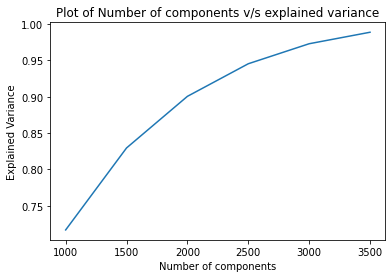

In [12]:
n_comp = [1000,1500,2000,2500,3000,3500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    lsa.fit(X)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [13]:
t0 = time()

svd = TruncatedSVD(n_components=3000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

done in 51.337826s
Explained variance of the SVD step: 97%



#### KMEANS

In [24]:
km = KMeans(n_clusters=k, init='k-means++', max_iter=100)
km.fit(X)

KMeans(max_iter=100, n_clusters=5)

In [25]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: time series time series data series data time series forecasting series forecasting
Cluster 1: reinforcement learning learning rl reinforcement learning rl model based value function
Cluster 2: github com https github com https github available https github available https
Cluster 3: deep reinforcement deep reinforcement learning reinforcement learning learning drl reinforcement learning drl
Cluster 4: neural networks machine learning state art deep learning neural network


#### Visualization